In [16]:
import datetime
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### train_users_2.csv - the training set of users （训练数据）

### test_users.csv - the test set of users （测试数据）

#### 数据字典
1. id: user id （用户id）

2. date_account_created（帐号注册时间）: the date of account creation

3. timestamp_first_active（首次活跃时间）: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up

4. date_first_booking（首次订房时间）: date of first booking

5. gender（性别）

6. age（年龄）

7. signup_method（注册方式）

8. signup_flow（注册页面）: the page a user came to signup up from

9. language（语言）: international language preference

10. affiliate_channel（付费市场渠道）: what kind of paid marketing

11. affiliate_provider（付费市场渠道名称）: where the marketing is e.g. google, craigslist, other

12. first_affiliate_tracked（注册前第一个接触的市场渠道）: whats the first marketing the user interacted with before the signing up

13. signup_app（注册app）

14. first_device_type(设备类型)

15. first_browser（浏览器类型）

16. country_destination（订房国家-需要预测的量）: this is the target variable you are to predict


### sessions.csv - web sessions log for users（网页浏览数据）
#### 数据字典

1. user_id（用户id）: to be joined with the column ‘id’ in users table

2. action(用户行为)

3. action_type（用户行为类型）

4. action_detail（用户行为具体）

5. device_type（设备类型）

6. secs_elapsed（停留时长）


In [17]:
train = pd.read_csv("train_users_2.csv")
test = pd.read_csv("test_users.csv")

In [18]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [19]:
print('The columns name of training dataset:\n',train.columns,train.shape)
print("===========================================")
print('The columns name of test dataset:\n',test.columns,test.shape)

The columns name of training dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object') (213451, 16)
The columns name of test dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object') (62096, 15)


### 绘制用户增长曲线

In [20]:
# 更改账户创建时间格式
train['date_account_created'] = 
test['date_account_created'] = 

In [21]:
# 创建客户量的累积数量，计算当天的客户量加上前面所有的客户量
acc_cum = 
acc_cum.head()

,date_account_created,id
0,2010-01-01,1
1,2010-01-02,2
2,2010-01-03,3
3,2010-01-04,6
4,2010-01-05,9


In [22]:
# 计算注册日期距离初始日期的天数
acc_cum['days'] = 
acc_cum.head()

,date_account_created,id,days
0,2010-01-01,1,0
1,2010-01-02,2,1
2,2010-01-03,3,2
3,2010-01-04,6,3
4,2010-01-05,9,4
5,2010-01-07,13,6
6,2010-01-08,14,7
7,2010-01-10,17,9
8,2010-01-11,20,10
9,2010-01-12,23,11


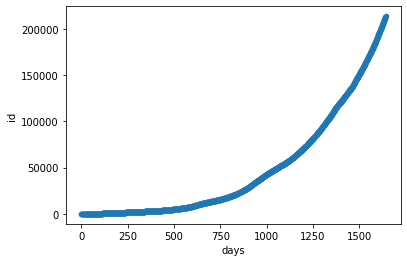

In [23]:
# 画出来每天累积的用户量


### 绘制日注册数量曲线 

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(12)
memory usage: 26.1+ MB


In [25]:
# 计算每个注册日期有多少人注册账户
dac_train = 
dac_test = 

In [26]:
# 找到所有注册日期值
dac_train_date = 
dac_test_date = 

In [27]:
# 计算注册日期距离初始日期的天数
dac_train_day = 
dac_test_day = 

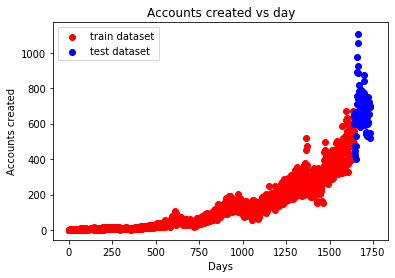

In [28]:
# 做图，横轴是注册日期距离初始日期的天数，纵轴是注册用户量


plt.title("Accounts created vs day")
plt.xlabel("Days")
plt.ylabel("Accounts created")
plt.legend(loc = 'upper left')

### 定义一个函数，功能为绘制每个类别变量(函数参数中的feature) barplot

In [34]:
def lookup_feature(feature, data_train = train, data_test = test, figsize=(8,8),saveimg = False): 
    # 提取特征，值计数
    train_feat = 
    test_feat = 
    # 创建画布和子图
   
    # 画图,分别绘制训练集和测试集图
    # 训练集
    
    plt.xticks(rotation=90)
    # 测试集
    
    plt.xticks(rotation=90)
    # 设置格式
    ax1.set_title(feature + ' of training dataset')
    ax2.set_title(feature + ' of test dataset')
    ax1.set_ylabel('Counts')
    #自动调整图像空隙
    plt.tight_layout()
    # 保存图片
    if saveimg == True:
        # 图片名称
        figname = feature + ".png"
        #判断images目录里是否不存在
        if not os.path.exists('./images'):
            # 如果不存在,创建一个目录
            os.makedirs('./images')
            # 保存图像
            fig_feature.savefig('./images/'+figname, dpi = 75)

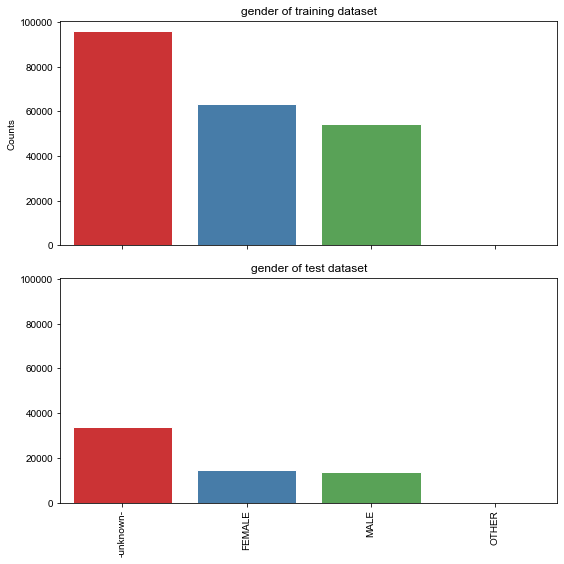

In [35]:
lookup_feature('gender', saveimg = True)

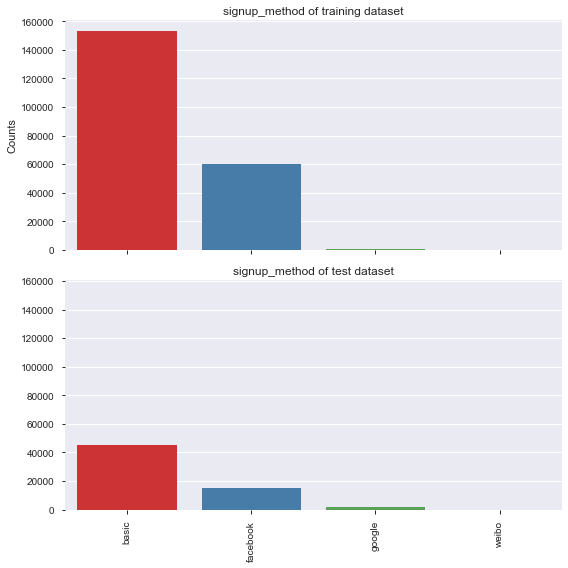

In [141]:
lookup_feature('signup_method')

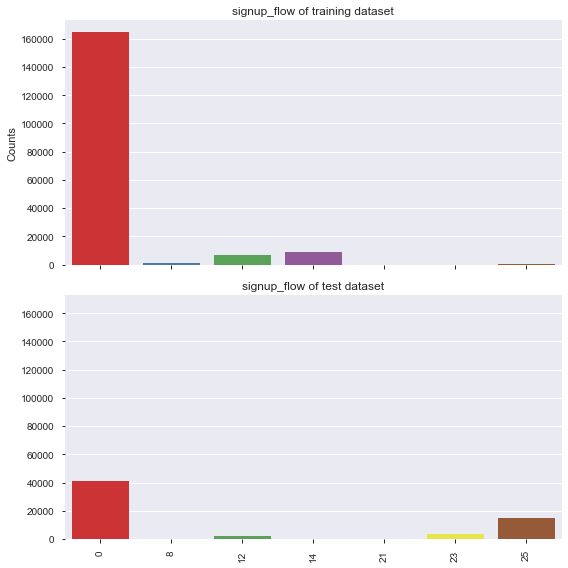

In [142]:
lookup_feature('signup_flow')

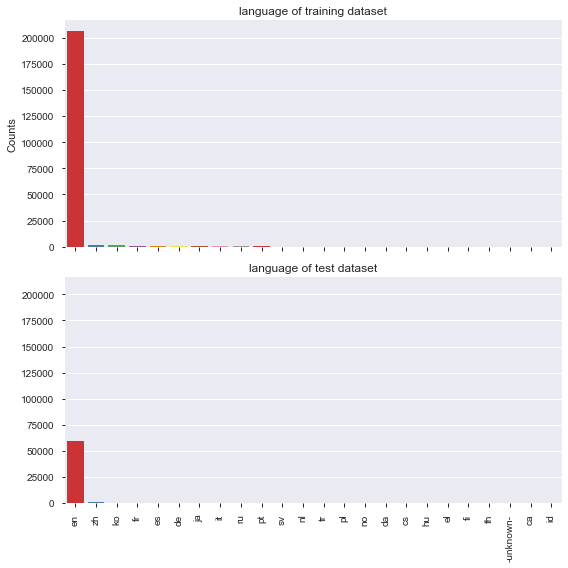

In [143]:
lookup_feature('language')

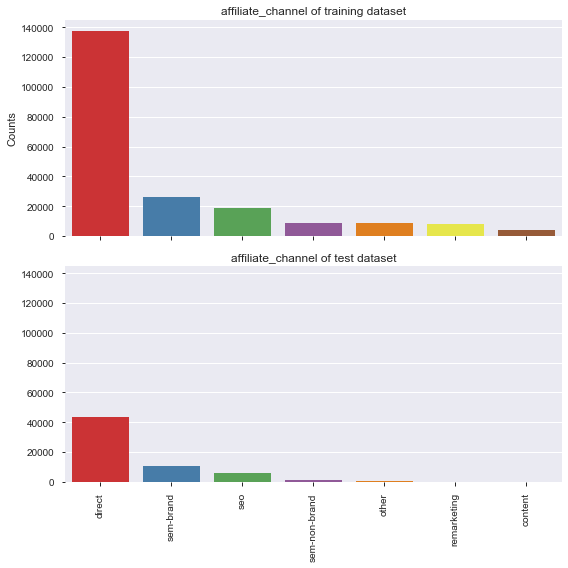

In [144]:
lookup_feature('affiliate_channel')

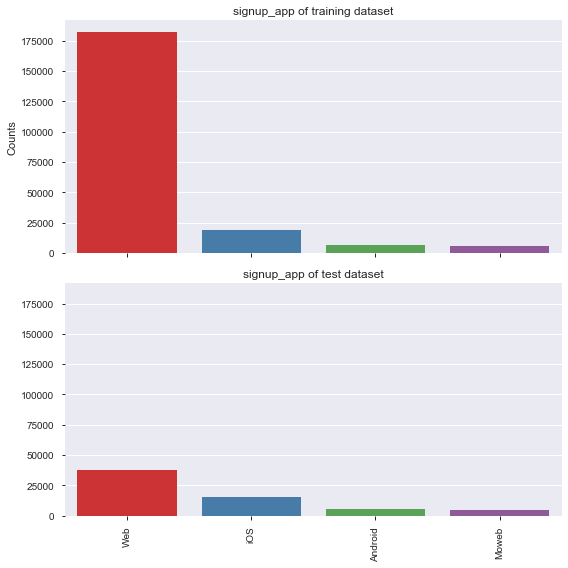

In [145]:
lookup_feature('signup_app')

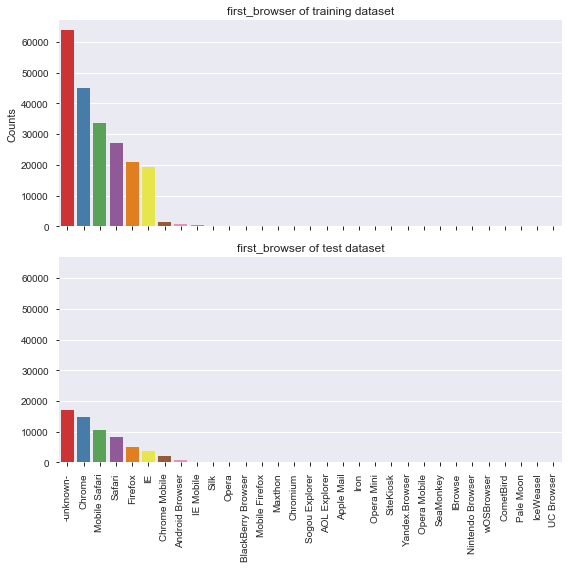

In [146]:
lookup_feature('first_browser')

#### 把首次活跃时间变成时间格式

In [24]:
train['timestamp_first_active'] = 
train['timestamp_first_active']    

0        2009-03-19 04:32:55
1        2009-05-23 17:48:09
2        2009-06-09 23:12:47
3        2009-10-31 06:01:29
4        2009-12-08 06:11:05
5        2010-01-01 21:56:19
6        2010-01-02 01:25:58
7        2010-01-03 19:19:05
8        2010-01-04 00:42:11
9        2010-01-04 02:37:58
10       2010-01-04 19:42:51
11       2010-01-05 05:18:12
12       2010-01-05 06:08:59
13       2010-01-05 08:32:59
14       2010-01-07 05:58:20
15       2010-01-07 20:45:55
16       2010-01-07 21:51:25
17       2010-01-07 22:46:25
18       2010-01-08 01:56:41
19       2010-01-10 01:08:17
20       2010-01-10 15:21:20
21       2010-01-10 22:09:41
22       2010-01-11 03:14:38
23       2010-01-11 22:40:15
24       2010-01-11 23:08:08
25       2010-01-12 13:14:44
26       2010-01-12 15:54:20
27       2010-01-12 20:59:49
28       2010-01-13 04:46:50
29       2010-01-13 06:43:33
                 ...        
213421   2014-06-30 23:11:37
213422   2014-06-30 23:12:46
213423   2014-06-30 23:15:48
213424   2014-